In [1]:
import os
import yaml
import joblib
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import train_test_split

from model import CINN
from plot_utils import (
    load_model_and_data,
    sample_posteriors,
    compute_map_estimates,
    build_priors_from_training,
)



In [2]:
TARGET_COLS = [
    'last_T_coll',
    'last_V_coll',
    'last_M_Crit500_coll',
    'last_Subcluster_mass',
    'last_Mass_ratio',
    'last_d_peri']


TARGET_UNITS = [
    r'$\mathrm{Gyr}$',                # last_T_coll
    r'$\mathrm{km/s}$',               # last_V_coll
    r'$10^{14}\,M_\odot$',            # last_M_Crit500_coll
    r'$10^{14}\,M_\odot$',            # last_Subcluster_mass
    r'' ,                             # last_Mass_ratio (unitless)
    r'$\mathrm{kpc}$',                # last_d_peri        
]


In [3]:
def plot_posteriors_all_targets(
    model_checkpoint: str,
    processed_dir: str = "processed_data",
    params_path: str = "params.yaml",
    n_samples_per_cluster: int = 100,
    random_state: int = 42,
    num_bins: int = 10,
    max_ticks: int = 5
):
    """
    Plot posterior-vs-truth histograms for all targets under the new embeddings→CINN→features pipeline.
    Top of each column shows the target label; bottom x-axis shows only the unit.
    """
    # ─── 1) Device ────────────────────────────────────────────────────────────────
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ─── 2) Load model, embeddings, Y, and scaler ─────────────────────────────────
    model, E_full, Y_full_rep, tar_sc = load_model_and_data(
        model_checkpoint=model_checkpoint,
        params_path=params_path,
        processed_dir=processed_dir,
        device=device
    )
    D_tar = Y_full_rep.shape[1]

    # ─── 3) Build test set ─────────────────────────────────────────────────────────
    N = len(E_full)
    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)

    E_test = E_full[idx_test]
    Y_test = Y_full_rep[idx_test]
    Y_test_phys = tar_sc.inverse_transform(Y_test)

    # ─── 4) Sample posterior draws in physical units ──────────────────────────────
    samples_phys = sample_posteriors(
        model,
        E_test,
        tar_sc,
        n_samples=n_samples_per_cluster,
        device=device
    )
    # samples_phys shape: (N_test, n_samples_per_cluster, D_tar_phys)

    all_data = []
    results = []

    # ─── 5) Build 2D histograms for each target dimension ──────────────────────────
    for d in range(D_tar):
        gt = Y_test_phys[:, d]
        bins = np.linspace(gt.min(), gt.max(), num_bins + 1)
        bin_idx = np.digitize(gt, bins[1:-1], right=False)
        bin_to_post = {b: [] for b in range(num_bins)}

        for i, b in enumerate(bin_idx):
            bin_to_post[b].append(samples_phys[i, :, d])

        counts = np.zeros((num_bins, num_bins), dtype=int)
        med_i = np.full(num_bins, np.nan)
        lo_i = np.full(num_bins, np.nan)
        hi_i = np.full(num_bins, np.nan)

        for b in range(num_bins):
            samples_list = bin_to_post[b]
            if samples_list:
                arr = np.concatenate(samples_list)
                counts[b], _ = np.histogram(arr, bins=bins)
                med_val = np.median(arr)
                med_i[b] = np.clip(np.digitize(med_val, bins) - 1, 0, num_bins - 1)
                lo_val = np.percentile(arr, 10)
                hi_val = np.percentile(arr, 90)
                lo_i[b] = np.clip(np.digitize(lo_val, bins) - 1, 0, num_bins - 1)
                hi_i[b] = np.clip(np.digitize(hi_val, bins) - 1, 0, num_bins - 1)

        data = counts.T
        all_data.append(data)
        results.append((data, med_i, lo_i, hi_i, bins))

    # ─── 6) Color scale and tick positions ────────────────────────────────────────
    flat = np.concatenate([d.flatten() for d in all_data])
    pos = flat[flat > 0]
    norm = LogNorm(vmin=max(1, pos.min() if pos.size else 1), vmax=flat.max())

    step = max(1, num_bins // max_ticks)
    tick_positions = np.arange(0, num_bins, step)
    if tick_positions[-1] != num_bins - 1:
        tick_positions = np.append(tick_positions, num_bins - 1)

    # ─── 7) Create subplots: one column per target ─────────────────────────────────
    fig, axes = plt.subplots(
        1, D_tar,
        figsize=(4 * D_tar, 5),
        squeeze=False
    )

    # ─── 8) Fill each subplot ──────────────────────────────────────────────────────
    for d, ax in enumerate(axes[0]):
        data, med_i, lo_i, hi_i, bins = results[d]
        ends = bins[1:]

        # 8a) Show 2D histogram
        im = ax.imshow(
            data,
            origin='lower',
            norm=norm,
            aspect='equal',
            interpolation='nearest',
            cmap='viridis'
        )

        # 8b) Diagonal line y=x
        ax.plot([0, num_bins - 1], [0, num_bins - 1], color='white', linewidth=2)

        # 8c) Smooth median and percentile curves
        x_smooth = np.linspace(0, num_bins - 1, num_bins * 10)
        ax.plot(
            x_smooth,
            np.interp(x_smooth, np.arange(num_bins), med_i),
            '-', lw=3, color='black'
        )
        ax.plot(
            x_smooth,
            np.interp(x_smooth, np.arange(num_bins), lo_i),
            '--', lw=2, color='black'
        )
        ax.plot(
            x_smooth,
            np.interp(x_smooth, np.arange(num_bins), hi_i),
            '--', lw=2, color='black'
        )

        # 8d) Top: target label
        ax.set_title(TARGET_COLS[d], fontsize=14, pad=10)

        # 8e) X‐axis ticks: positions correspond to bin indices
        ax.set_xticks(tick_positions)
        ax.set_xticklabels([f'{ends[i]:.2f}' for i in tick_positions],
                           rotation=90, fontsize=10)
        # 8f) Bottom: show unit only
        ax.set_xlabel(f"{TARGET_UNITS[d]}", fontsize=12, labelpad=8)

        # 8g) Y‐axis ticks also show bin boundaries labeled by ground‐truth edges
        ax.set_yticks(tick_positions)
        ax.set_yticklabels([f'{ends[i]:.2f}' for i in tick_positions], fontsize=10)
        if d == 0:
            ax.set_ylabel('Posterior sample bin', fontsize=12)

    # ─── 9) Colorbar ───────────────────────────────────────────────────────────────
    divider = make_axes_locatable(axes[0][-1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    fig.colorbar(im, cax=cax).set_label('Number of samples (log scale)', fontsize=12)

    plt.tight_layout()
    plt.savefig("2.prediction_performance1.png", dpi=300)
    #plt.savefig("2.prediction_performance1.pdf", dpi=300)
    plt.show()

    #return results

/vera/u/jshera/CL/new_venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/vera/u/jshera/CL/new_venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


num samples out of bounds: 0
number of parameters: 1761976
GraphINN(
  (module_list): ModuleList(
    (0-7): 8 x RationalQuadraticSplineBlock(
      (softplus): Softplus(beta=0.5, threshold=20.0)
      (subnet): Subnet(
        (layers): Sequential(
          (0): Linear(in_features=515, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): ReLU()
          (4): Linear(in_features=256, out_features=87, bias=True)
        )
      )
    )
  )
)


/vera/u/jshera/CINN_spline/representation_space/plot_utils.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


num samples out of bounds: 0
number of parameters: 1761976
GraphINN(
  (module_list): ModuleList(
    (0-7): 8 x RationalQuadraticSplineBlock(
      (softplus): Softplus(beta=0.5, threshold=20.0)
      (subnet): Subnet(
        (layers): Sequential(
          (0): Linear(in_features=515, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): ReLU()
          (4): Linear(in_features=256, out_features=87, bias=True)
        )
      )
    )
  )
)
num samples out of bounds: 0
number of parameters: 1761976
GraphINN(
  (module_list): ModuleList(
    (0-7): 8 x RationalQuadraticSplineBlock(
      (softplus): Softplus(beta=0.5, threshold=20.0)
      (subnet): Subnet(
        (layers): Sequential(
          (0): Linear(in_features=515, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): ReLU()
          (4): Linear(in_features=256, out_

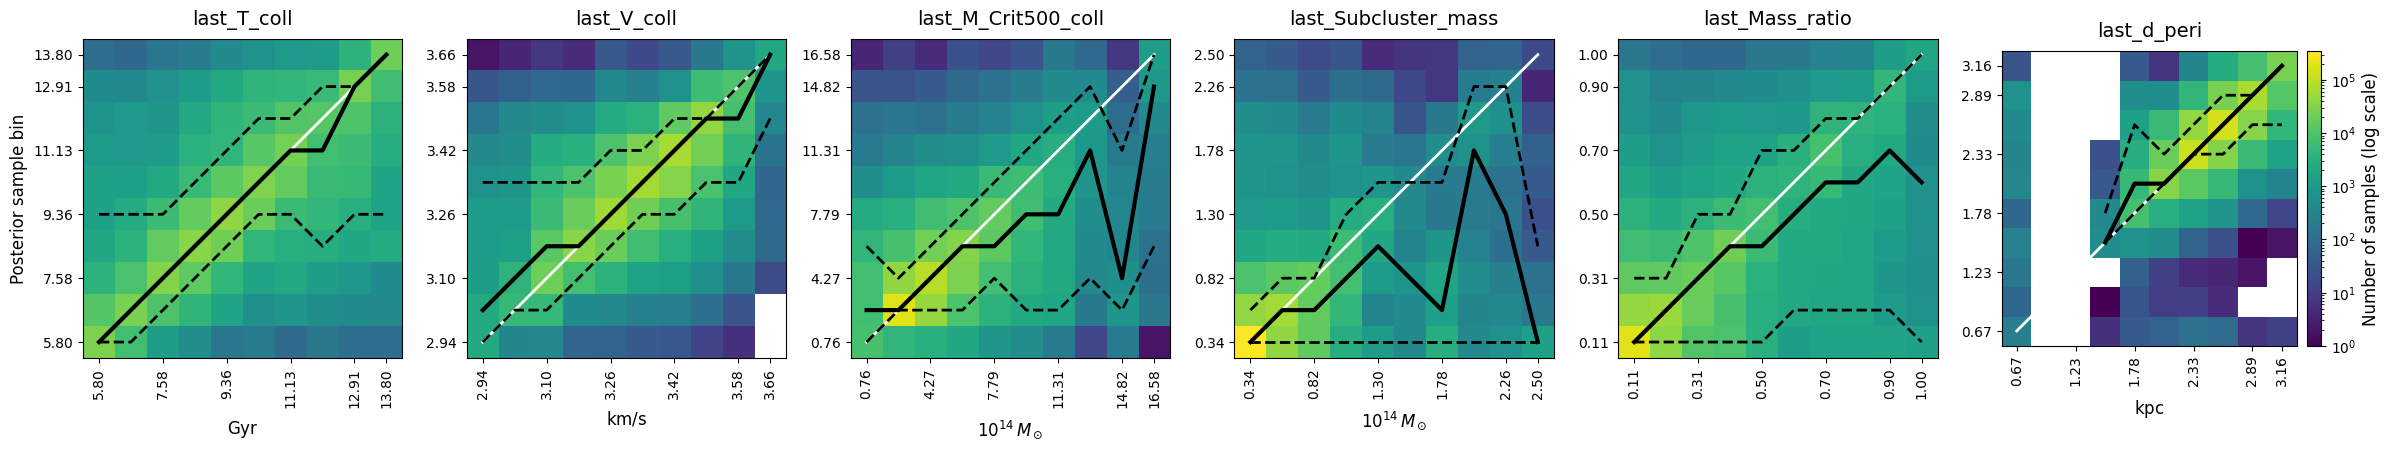

In [4]:
plot_posteriors_all_targets(
    model_checkpoint="experts/",
    processed_dir="processed_data",
    params_path="params.yaml",
    n_samples_per_cluster=1000,
    random_state=42,
    num_bins=10,
    max_ticks=5
)

In [5]:
def plot_map_and_error_vs_truth(
    model_checkpoint: str,
    processed_dir: str = "processed_data",
    params_path: str = "params.yaml",
    n_posterior_samples: int = 600,
    num_bins: int = 10,
    linthresh: float | list[float] = 0.1,
    random_state: int = 42,
    label_fontsize: int = 14,
    title_fontsize: int = 18
):
    """
    Plot MAP vs. Truth (top row) and MAP−Truth vs. Truth (bottom row)
    for each target under the embeddings→CINN→features pipeline,
    with target label on top and only the unit under the x-axis.
    The bottom‐row y‐axis now uses a linear scale instead of symlog,
    but linthresh is still accepted (it will be ignored in this version).
    
    Parameters:
      linthresh: This parameter is accepted for compatibility but is not used—
                 bottom‐row remains a linear scale.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ─── 1) Load model, embeddings, scaled‐targets Y, and scaler ───────────────────────
    model, E_full, Y_full, tar_sc = load_model_and_data(
        model_checkpoint=model_checkpoint,
        params_path=params_path,
        processed_dir=processed_dir,
        device=device
    )
    N, D_emb = E_full.shape
    _, D_tar = Y_full.shape
    assert D_tar == len(TARGET_COLS), "TARGET_COLS length must match number of target dims"

    # ─── 2) Build test set by splitting 10% of the projections ────────────────────────
    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)

    E_test = E_full[idx_test]                    # (N_test, D_emb)
    Y_test = Y_full[idx_test]                    # (N_test, D_tar_scaled)
    true_phys = tar_sc.inverse_transform(Y_test)  # (N_test, D_tar_phys)

    # ─── 3) Sample posterior draws (physical units) and compute MAPs ─────────────────
    samples_phys = sample_posteriors(
        model,
        E_test,
        tar_sc,
        n_samples=n_posterior_samples,
        device=device
    )
    # samples_phys shape = (N_test, n_posterior_samples, D_tar_phys)

    maps_phys = compute_map_estimates(samples_phys, bandwidth=0.5)  # (N_test, D_tar_phys)

    # ─── 4) Set up figure: 2 rows × D_tar columns ───────────────────────────────────
    fig, axes = plt.subplots(
        2,
        D_tar,
        figsize=(4 * D_tar, 10),
        squeeze=False
    )

    for d in range(D_tar):
        truth = true_phys[:, d]
        mapv = maps_phys[:, d]
        error = mapv - truth

        tmin, tmax = truth.min(), truth.max()
        bins = np.linspace(tmin, tmax, num_bins + 1)
        centers = 0.5 * (bins[:-1] + bins[1:])
        inds = np.digitize(truth, bins) - 1  # which bin each truth falls into

        # ─── Top row: MAP vs Truth ───────────────────────────────────────────────────
        ax1 = axes[0, d]
        ax1.scatter(truth, mapv, s=20, alpha=0.6)
        ax1.plot([tmin, tmax], [tmin, tmax], color='peachpuff', linewidth=2)

        ax1.set_xlim(tmin, tmax)
        ax1.set_ylim(tmin, tmax)
        ax1.set_title(TARGET_COLS[d], fontsize=title_fontsize)
        # Only the unit under the x‐axis (no "Ground Truth" text)
        ax1.set_xlabel(TARGET_UNITS[d], fontsize=label_fontsize)
        if d == 0:
            ax1.set_ylabel("MAP Estimate", fontsize=label_fontsize)
        ax1.tick_params(axis='both', labelsize=label_fontsize)

        # ─── Bottom row: Error vs Truth ───────────────────────────────────────────────
        ax2 = axes[1, d]
        ax2.scatter(truth, error, s=20, alpha=0.6)
        ax2.axhline(0, color='peachpuff', linewidth=2)

        # Compute median, 10th, and 90th percentiles of error in each truth‐bin
        med_err = np.full(num_bins, np.nan)
        lo_err = np.full(num_bins, np.nan)
        hi_err = np.full(num_bins, np.nan)

        for i_bin in range(num_bins):
            sel = error[inds == i_bin]
            if sel.size > 0:
                med_err[i_bin] = np.median(sel)
                lo_err[i_bin], hi_err[i_bin] = np.percentile(sel, [10, 90])

        ax2.plot(centers, med_err, '-', linewidth=1.5, color='black')
        ax2.plot(centers, lo_err, '--', linewidth=1.2, color='black')
        ax2.plot(centers, hi_err, '--', linewidth=1.2, color='black')

        # Bottom‐row uses a LIN­EAR scale (ignoring linthresh)
        ax2.set_yscale("linear")

        ax2.set_xlim(tmin, tmax)
        # Only the unit under the x‐axis (no "Ground Truth" text)
        ax2.set_xlabel(TARGET_UNITS[d], fontsize=label_fontsize)
        if d == 0:
            ax2.set_ylabel("MAP − Truth", fontsize=label_fontsize)
        ax2.tick_params(axis='both', labelsize=label_fontsize)

    plt.tight_layout()
    plt.savefig("2.prediction_performance2.png", dpi=300)
    #plt.savefig("2.prediction_performance2.pdf", dpi=300)
    plt.show()

/vera/u/jshera/CL/new_venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/vera/u/jshera/CL/new_venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


num samples out of bounds: 0
number of parameters: 1761976
GraphINN(
  (module_list): ModuleList(
    (0-7): 8 x RationalQuadraticSplineBlock(
      (softplus): Softplus(beta=0.5, threshold=20.0)
      (subnet): Subnet(
        (layers): Sequential(
          (0): Linear(in_features=515, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): ReLU()
          (4): Linear(in_features=256, out_features=87, bias=True)
        )
      )
    )
  )
)


/vera/u/jshera/CINN_spline/representation_space/plot_utils.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


num samples out of bounds: 0
number of parameters: 1761976
GraphINN(
  (module_list): ModuleList(
    (0-7): 8 x RationalQuadraticSplineBlock(
      (softplus): Softplus(beta=0.5, threshold=20.0)
      (subnet): Subnet(
        (layers): Sequential(
          (0): Linear(in_features=515, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): ReLU()
          (4): Linear(in_features=256, out_features=87, bias=True)
        )
      )
    )
  )
)
num samples out of bounds: 0
number of parameters: 1761976
GraphINN(
  (module_list): ModuleList(
    (0-7): 8 x RationalQuadraticSplineBlock(
      (softplus): Softplus(beta=0.5, threshold=20.0)
      (subnet): Subnet(
        (layers): Sequential(
          (0): Linear(in_features=515, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): ReLU()
          (4): Linear(in_features=256, out_

GraphINN(
  (module_list): ModuleList(
    (0-7): 8 x RationalQuadraticSplineBlock(
      (softplus): Softplus(beta=0.5, threshold=20.0)
      (subnet): Subnet(
        (layers): Sequential(
          (0): Linear(in_features=515, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): ReLU()
          (4): Linear(in_features=256, out_features=87, bias=True)
        )
      )
    )
  )
)


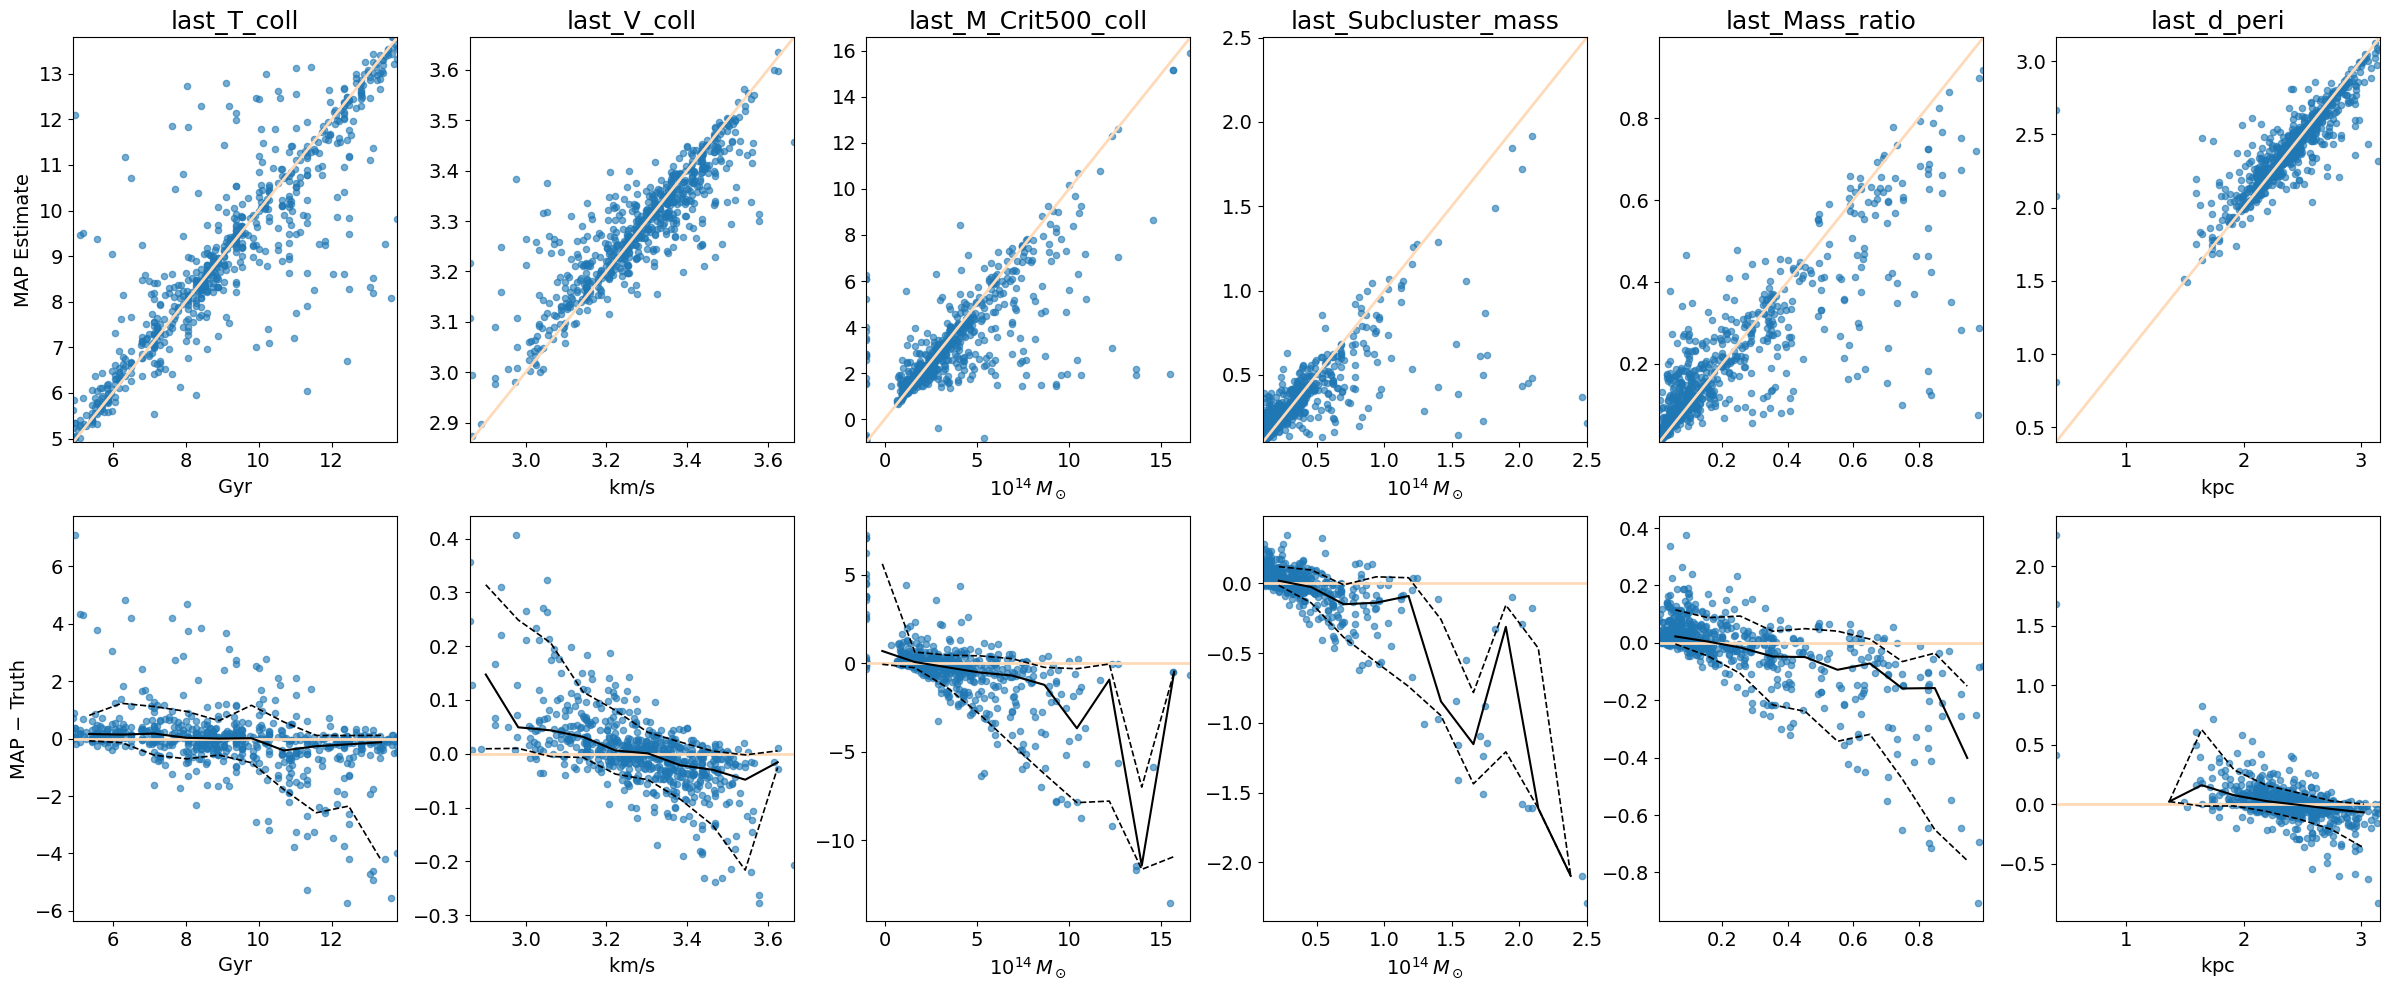

In [6]:
plot_map_and_error_vs_truth(
    model_checkpoint="experts/",
    processed_dir="processed_data",
    params_path="params.yaml",
    n_posterior_samples=600,
    num_bins=10,
    linthresh=[10, 0.1, 10, 10, 10, 10],  # per-target linthresh
)